## Loading required packages

In [32]:
# basic package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for accessinng the directories
import os
import shutil # for removing the unwanted directories

# from the model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # for the layers
from tensorflow.keras.utils import image_dataset_from_directory #
from keras.preprocessing.image import ImageDataGenerator # For data augmentation
from keras.applications.vgg16 import preprocess_input # VGG16 preprocessing fuction


from sklearn.metrics import confusion_matrix, classification_report , accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc


__Checking if  `GPU` is connected__

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Obtaining the data

### Finding out the `best 3 classes` of birds using training data

In [3]:

data_dir = "../../data/train/" # train directory

# List all class folders
class_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

# Create a dictionary to store class names and their respective image counts
class_counts = {}
for folder in class_folders:
    class_path = os.path.join(data_dir, folder)
    num_images = len(os.listdir(class_path))
    class_counts[folder] = num_images

# Sort classes by the number of images and select the top 3
top_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:3]

# Extract class names
selected_classes = [cls[0] for cls in top_classes]
print("Selected Classes:", selected_classes)


Selected Classes: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


#### Removing extra classes

In [4]:
import shutil # for removing the unwanted directories

def remove_folder(dir_path,classes):
    items = os.listdir(dir_path)
    for i in items:
        if i not in classes:
            file = (os.path.join(dir_path,i))
            # os.remove(file)
            shutil.rmtree(file)
            

In [5]:
train_dir = "../../data/train/" # train directory
test_dir = "../../data/test/" # test directory
val_dir = "../../data/valid/" # validation directory


# Removing extra directories
remove_folder(train_dir,selected_classes)
remove_folder(test_dir,selected_classes)
remove_folder(val_dir,selected_classes)

### 2. Data Augmentation

In [6]:
augmented_data = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = augmented_data.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

validation_generator = augmented_data.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)


test_datagen = ImageDataGenerator() #only for testing

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [7]:
img_labels = {0: 'D-ARNAUDS BARBET', 1:'HOUSE FINCH', 2:'RUFOUS TREPE'}

### Visualising the images

In [8]:
def plot_img(generator):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        image, labels = train_generator.next()
        plt.subplot(4, 5, i + 1)
        plt.imshow(image[0].astype("uint8"))
        label = (np.argmax(labels[i]))
        plt.title(img_labels[label],fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

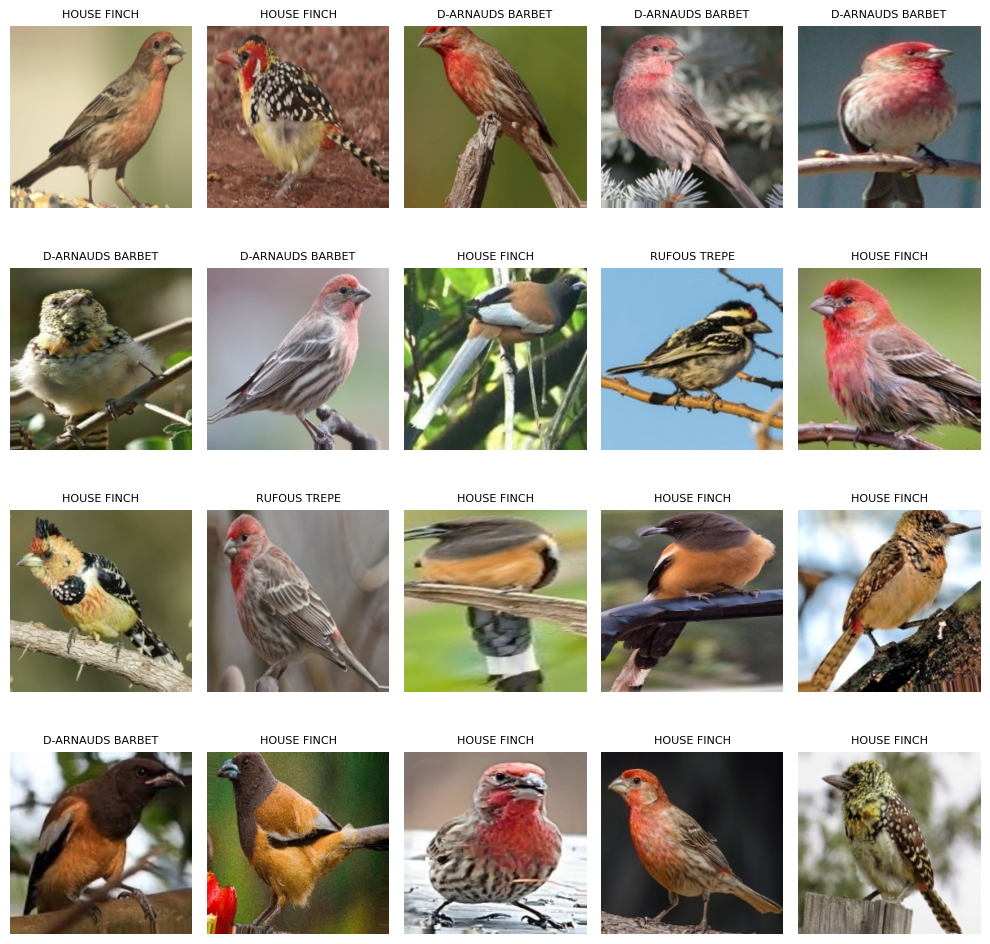

<Figure size 640x480 with 0 Axes>

In [9]:
plot_img(train_generator)


## 3. Fine-Tune

### Loading the `VGG16` model

In [10]:
vgg_model1 = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

In [11]:
# Making useful functions
def loss_acc(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    acc = history["accuracy"]
    epochs = range(1, len(acc) + 1)
    # Plot loss on the first subplot
    axes[0].scatter(epochs, history['loss'], label='Training Loss')
    axes[0].plot(epochs, history['val_loss'], label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot accuracy on the second subplot
    axes[1].scatter(epochs, history['accuracy'], label='Training Accuracy')
    axes[1].plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    

In [12]:
vgg_model1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Making the trainable `False`

In [13]:
vgg_model1.trainable = False

In [14]:
vgg_model1.summary() #after making all the layers for training as False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Model 1

- Input = [224,224,3]
- hidden layer 1 (non-trainable) -> vgg16 preprocess_input
- hidden layer 2 (non-trainable) -> vgg16 model
- hidden layer 3 (non-trainable) -> Flatten layer
- hidden layer 4 -> FC (128)
- hidden layer 5 (non-trainable) -> dropout layer (0.2) 
- hidden layer 6 -> FC (32)
- hidden layer 7 (non-trainable) -> dropout layer (0.2) 
- ouput layer -> FC (3 , `softmax`)

- epochs -> 10
- batch size -> 32
- optimizer -> `Adam`
- loss function -> `categorical_crossentropy`


In [15]:

inputs = keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = vgg_model1(x)
x = layers.Flatten()(x)

x = layers.Dense(128,activation='relu')(x)
x=  layers.Dropout(0.2)(x)


x = layers.Dense(32,activation='relu')(x)
x=  layers.Dropout(0.2)(x)

outputs = layers.Dense(3, activation="softmax")(x)
model1 = keras.Model(inputs, outputs)

In [16]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                             

In [17]:
model1.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

history1 = model1.fit(
    train_generator,
    batch_size=32,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
24/24 [==============================] - 82s 3s/step - loss: 4.5632 - accuracy: 0.8293 - val_loss: 9.0598e-07 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 29s 1s/step - loss: 0.9960 - accuracy: 0.9476 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 22s 895ms/step - loss: 0.7035 - accuracy: 0.9718 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 89s 4s/step - loss: 0.4926 - accuracy: 0.9731 - val_loss: 1.5895e-08 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 27s 1s/step - loss: 0.6325 - accuracy: 0.9798 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 26s 1s/step - loss: 0.3776 - accuracy: 0.9866 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 20s 838ms/step - loss: 0.6850 - accuracy: 0.9785 - val_loss: 0.0000e+00 - val_acc

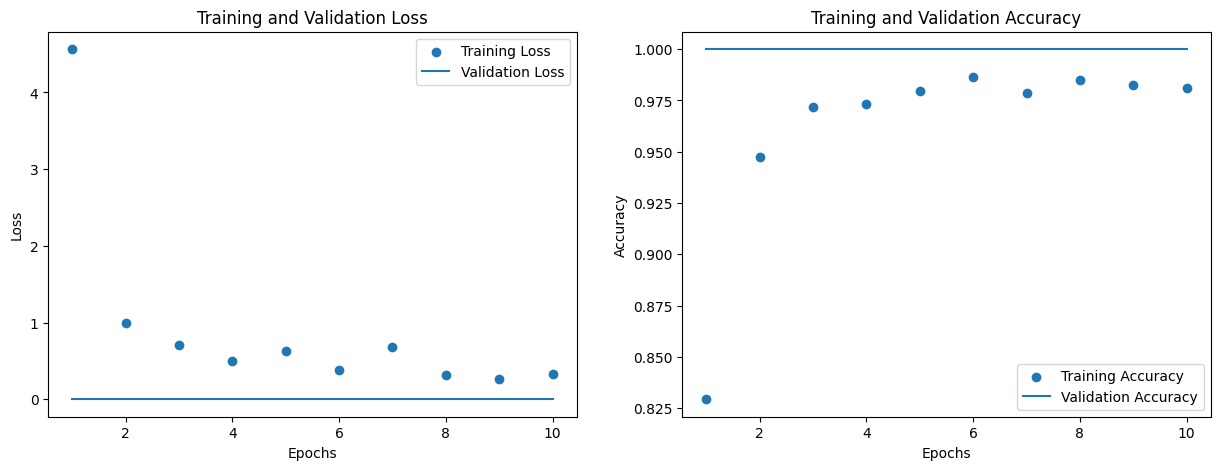

In [18]:
loss_acc(history1.history)

The preformance of the model is `excellent` achieving the accuracy of the 100% and loss of alsmost 0%
- thus we can try to `build` a relatively `less complex model`


#### Model 2

- Input = [224,224,3]
- hidden layer 1 (non-trainable) -> vgg16 preprocess_input
- hidden layer 2 (non-trainable) -> vgg16 model
- hidden layer 3 (non-trainable) -> Flatten layer
- hidden layer 4 -> FC (32)
- ouput layer -> FC (3 , `softmax`)

- epochs -> 3
- batch size -> 32
- optimizer -> `Adam`
- loss function -> `categorical_crossentropy`


In [19]:
vgg_model2 = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

In [20]:
vgg_model2.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = vgg_model2(x)
x = layers.Flatten()(x)

x = layers.Dense(32,activation='relu')(x)

outputs = layers.Dense(3, activation="softmax")(x)
model2 = keras.Model(inputs, outputs)

In [21]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                8028

In [22]:
model2.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

history2 = model2.fit(
    train_generator,
    batch_size=32,
    epochs=3,
    validation_data=validation_generator
)

Epoch 1/3
24/24 [==============================] - 32s 1s/step - loss: 5.8942 - accuracy: 0.8347 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 2/3
24/24 [==============================] - 29s 1s/step - loss: 0.0403 - accuracy: 0.9879 - val_loss: 0.0427 - val_accuracy: 1.0000
Epoch 3/3
24/24 [==============================] - 22s 893ms/step - loss: 0.0223 - accuracy: 0.9933 - val_loss: 0.0770 - val_accuracy: 1.0000


### Training the `vgg-16` last four layers

In [23]:
vgg_model2.trainable = True

for layer in vgg_model2.layers[:-4]:
    layers.trainable = False


In [24]:
vgg_model2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                8028

In [26]:
model2.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

history2 = model1.fit(
    train_generator,
    batch_size=32,
    epochs=3,
    validation_data=validation_generator
)

Epoch 1/3
24/24 [==============================] - 33s 1s/step - loss: 0.1707 - accuracy: 0.9906 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
24/24 [==============================] - 43s 2s/step - loss: 0.0787 - accuracy: 0.9946 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
24/24 [==============================] - 20s 820ms/step - loss: 0.1719 - accuracy: 0.9933 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


## 4. model performance

In [27]:
def model_eval(model,test_data):
    # Make predictions
    predictions = model.predict(test_data)

    # Convert predictions to class labels
    y_pred = np.argmax(predictions, axis=1)
    y_pred

    # True labels
    y_test = test_generator.classes
    y_test
    
    eval = {}
    eval['Accuracy'] = accuracy_score(y_test, y_pred)*100
    eval['Precision'] = precision_score(y_test, y_pred, average='weighted')*100
    eval['Recall'] = recall_score(y_test, y_pred, average='weighted')*100
    eval['f1 score'] = f1_score(y_test, y_pred, average='weighted')*100
    for k,v in eval.items():
        print(f"{k}\t{v:.2f}")
    return y_test,y_pred

### score calculation

In [48]:
y_test, y_pred = model_eval(model1,test_generator)

1/1 [==============================] - 0s 138ms/step
Accuracy	53.33
Precision	53.33
Recall	53.33
f1 score	53.33


### Confusion Matrics

<Axes: >

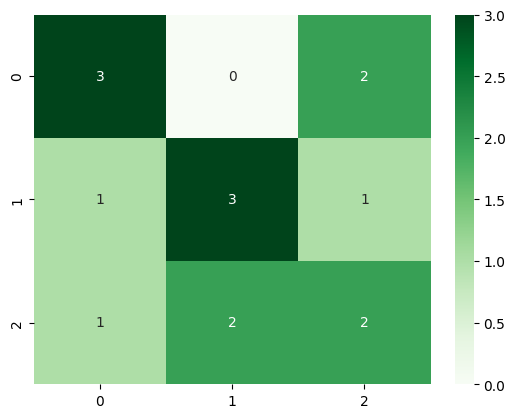

In [49]:
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True , cmap='Greens',fmt=".0f")

### precision recall curve  and  its area under the curve (AUC)

In [50]:
from keras.utils import to_categorical

1/1 [==============================] - 0s 221ms/step


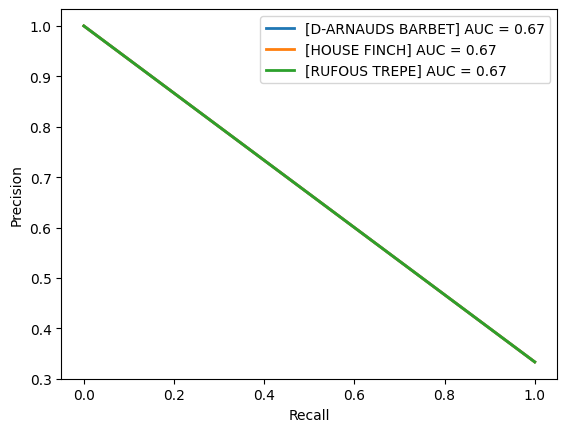

In [53]:
# prediction labels
pred = model1.predict(test_generator)

# True labels
true = test_generator.classes
true = to_categorical(true)
for i in range(3):
    actual = true[:, i]
    predictions = pred[:, i]
    precision, recall, _ = precision_recall_curve(actual, predictions)
    label = f"[{img_labels[i]}] AUC = {auc(recall, precision):.2f}"
    plt.plot(recall,precision,lw=2,label=label)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

The preformance of model in train and validation is `perfect (100%)`.
however, on test data the model is preforming `very bad (random guessing)`
__Therefore this is clearly a case of `underfitting`. though we used the technique of `data augmentation` then also the `data is not enough` to be trained on__

### Exploring specific examples in which the model failed to predict correctly.

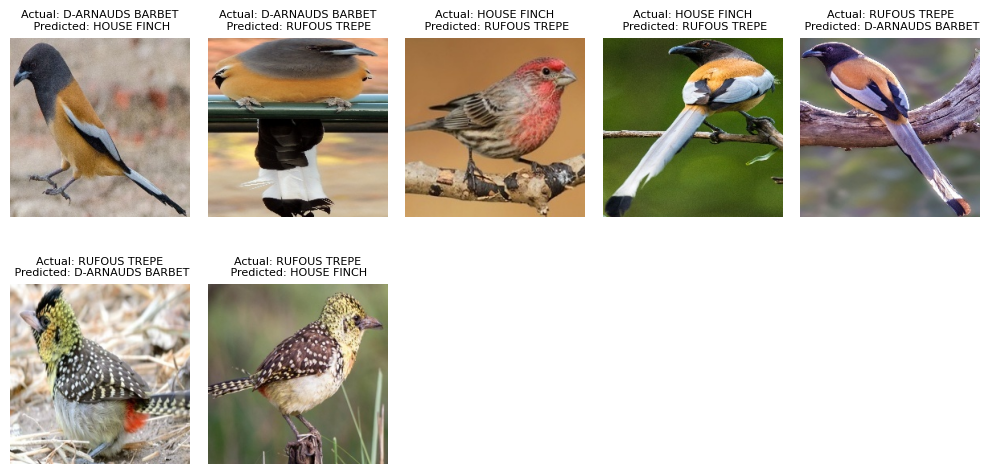

In [54]:
misclassifiedIndices = np.where(y_pred != y_test)[0]

plt.figure(figsize=(10, 10))
for idx,i in enumerate(misclassifiedIndices):
    
    # doing calculations to find the image in the test_generator 
    batchIndex = i // test_generator.batch_size
    batch, _ = test_generator[batchIndex]
    imageIndexInsideBatch = i % test_generator.batch_size
    img = batch[imageIndexInsideBatch] #misclassification image

    
    actualLabel = img_labels[y_test[i]]
    predictedLabel = img_labels[y_pred[i]]

    plt.subplot(4, 5, idx + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"Actual: {actualLabel}\n Predicted: {predictedLabel}",fontsize=8)
    plt.axis("off")
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()